In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.cluster import HDBSCAN
from scipy.signal import ShortTimeFFT
from sklearn.preprocessing import StandardScaler

#### DAFgrad Code

In [2]:
def sph_to_cart(theta_deg, phi_deg, mag=1.0):
    th = np.deg2rad(theta_deg)
    ph = np.deg2rad(phi_deg)
    return np.array([
        mag*np.sin(th)*np.cos(ph),
        mag*np.sin(th)*np.sin(ph),
        mag*np.cos(th)
    ], float)

def hat(v):
    v = np.asarray(v, dtype=float)
    n = np.linalg.norm(v)
    if n == 0:
        raise ValueError("Zero vector cannot be normalized")
    return v / n

def make_skew_frame(dirs):
    """
    Build 3x3 skewed frame:
    first len(dirs) columns are exactly the given unit directions,
    remaining column(s) just complete a basis.
    """
    dirs = [hat(v) for v in dirs]
    m = len(dirs)

    if m == 0:
        return np.eye(3)

    if m == 1:
        v1 = dirs[0]
        cand = np.array([1.0, 0.0, 0.0]) if abs(v1[0]) < 0.9 else np.array([0.0, 1.0, 0.0])
        u2 = hat(cand - np.dot(cand, v1) * v1)
        u3 = hat(np.cross(v1, u2))
        return np.column_stack([v1, u2, u3])

    if m == 2:
        v1, v2 = dirs
        # If nearly colinear, tweak v2
        if np.linalg.norm(np.cross(v1, v2)) < 1e-6:
            cand = np.array([1.0, 0.0, 0.0])
            v2 = hat(cand - np.dot(cand, v1) * v1)
        u3 = hat(np.cross(v1, v2))
        return np.column_stack([v1, v2, u3])

    # m >= 3: just take first three directions as they are
    v1, v2, v3 = dirs[:3]
    return np.column_stack([v1, v2, v3])

def dafgrad_clean(B, h1_dirs, h2_dirs, k_gain):
    """
    Dual-sensor DAFgrad in skewed frames.

    B        : (2, 3, N)
    h1_dirs  : (m, 3) unit disturbance directions at sensor 1
    h2_dirs  : (m, 3) unit disturbance directions at sensor 2
    k_gain   : (m,)  gains, |H2_k| / |H1_k| for each source k

    Returns:
        B_clean : (2, 3, N) cleaned signals (both sensors, identical in theory)
    """
    B = np.asarray(B, float)
    if B.shape[0] != 2 or B.shape[1] != 3:
        raise ValueError("B must have shape (2, 3, N)")

    h1_dirs = np.asarray(h1_dirs, float)
    h2_dirs = np.asarray(h2_dirs, float)
    k_gain = np.asarray(k_gain, float)

    if h1_dirs.shape != h2_dirs.shape:
        raise ValueError("h1_dirs and h2_dirs must have same shape")

    m = h1_dirs.shape[0]
    if k_gain.shape[0] != m:
        raise ValueError("k_gain length must match number of sources")

    # Unit direction vectors
    h1 = np.array([hat(v) for v in h1_dirs])
    h2 = np.array([hat(v) for v in h2_dirs])

    # Reconstruct disturbance vectors up to scale:
    # choose |H1_k| = 1, |H2_k| = k_gain[k]
    H1 = np.array([h1[k] for k in range(m)])
    H2 = np.array([k_gain[k] * h2[k] for k in range(m)])

    # Difference disturbance vectors and scaling factors
    HDelta = H1 - H2
    hD = np.array([hat(v) for v in HDelta])

    denom = np.linalg.norm(HDelta, axis=1)
    if np.any(denom < 1e-12):
        raise ValueError("Degenerate H1 - H2 for some source")

    alpha1 = np.linalg.norm(H1, axis=1) / denom
    alpha2 = np.linalg.norm(H2, axis=1) / denom

    # Build skewed frames: columns aligned with disturbance directions
    T1_inv = make_skew_frame(list(h1))
    T2_inv = make_skew_frame(list(h2))
    TD_inv = make_skew_frame(list(hD))

    T1 = np.linalg.inv(T1_inv)
    T2 = np.linalg.inv(T2_inv)
    TD = np.linalg.inv(TD_inv)

    # Project signals
    B1 = B[0].T        # (N,3)
    B2 = B[1].T
    BD = B1 - B2

    B1_p = (T1 @ B1.T).T
    B2_p = (T2 @ B2.T).T
    BD_p = (TD @ BD.T).T

    # Subtract along disturbance-aligned components
    B1_p_clean = B1_p.copy()
    B2_p_clean = B2_p.copy()
    for k in range(m):
        B1_p_clean[:, k] -= alpha1[k] * BD_p[:, k]
        B2_p_clean[:, k] -= alpha2[k] * BD_p[:, k]

    # Transform back
    B1_c = (T1_inv @ B1_p_clean.T).T
    B2_c = (T2_inv @ B2_p_clean.T).T

    B_clean = np.empty_like(B)
    B_clean[0] = B1_c.T
    B_clean[1] = B2_c.T
    return B_clean

#### Create Mixed Signals

In [3]:
"Create Mixed Signals"
fs=40.0
Tsec=120.0
seed=1

"""Two triaxial sensors, shared ambient + 2 deterministic disturbances."""
rng = np.random.default_rng(seed)
t = np.arange(0, Tsec, 1.0/fs)
N = t.size

# Ambient Field Signal
B0 = np.column_stack([
    0.4*np.sin(2*np.pi*0.04*t) + 0.6*np.cos(2*np.pi*0.1*t),
    0.4*np.cos(2*np.pi*0.03*t + 0.6) + 0.6*np.sin(2*np.pi*0.1*t),
    0.3*np.sin(2*np.pi*0.025*t + 1.1) + 0.7*np.cos(2*np.pi*0.05*t),
]) + np.array([3, -2, 1])[None, :]

# Interference Signals
S_A = np.sin(2*np.pi*(0.12*t + 0.001*t**2))
S_B = 0.6*np.sin(2*np.pi*(0.26*t - 0.0008*t**2) + 0.4) + signal.square(2*np.pi*1*t)*0.4
S_C = signal.sawtooth(2*np.pi*0.5*t)

H1A = sph_to_cart(50, 240, 20); H2A = sph_to_cart(52, 132, 1)
H1B = sph_to_cart(180,  50, 10); H2B = sph_to_cart(44, 100, 1)
H1C = sph_to_cart(120, 300, 15); H2C = sph_to_cart(130, -210, 0.5)

h1_true = np.array([hat(H1A), hat(H1B), hat(H1C)])
h2_true = np.array([hat(H2A), hat(H2B), hat(H2C)])
k_true = np.array([
    np.linalg.norm(H2A)/np.linalg.norm(H1A),
    np.linalg.norm(H2B)/np.linalg.norm(H1B),
    np.linalg.norm(H2C)/np.linalg.norm(H1C),
])

# Create Mixed Signals
b1 = np.outer(S_A, H1A) + np.outer(S_B, H1B) + np.outer(S_C, H1C)
b2 = np.outer(S_A, H2A) + np.outer(S_B, H2B) + np.outer(S_C, H2C)
B = np.zeros((2, 3, N))
B[0] = (B0 + b1).T
B[1] = (B0 + b2).T

#### Clean Signals with Known Gain and Directions

Text(0, 0.5, 'Magnetic Field Components')

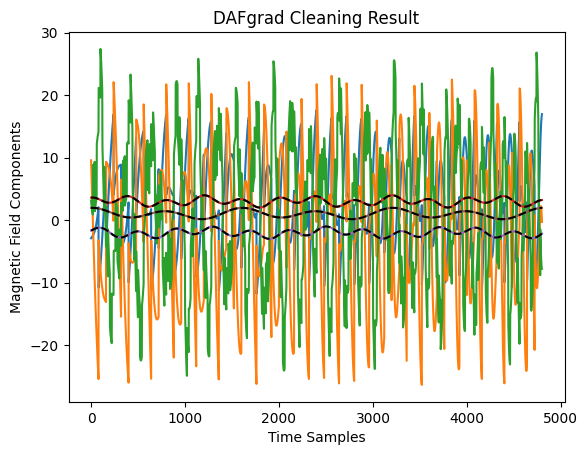

In [4]:
B_clean = dafgrad_clean(
    B,
    h1_dirs=h1_true,
    h2_dirs=h2_true,
    k_gain=k_true,
)

plt.plot(B[0].T, label='Sensor 0')
plt.plot(B_clean[1].T, label='Cleaned Sensor 1')
plt.plot(B0, color='black', linestyle='dashed', label = 'Ambient Field')
plt.title('DAFgrad Cleaning Result')
plt.xlabel('Time Samples')
plt.ylabel('Magnetic Field Components')

#### Take Time-Frequency Transform

In [5]:
from scipy.signal.windows import hann
window = hann(256)
SFT = ShortTimeFFT(win = window, hop = 100, fs = fs)
Sf = SFT.stft(B, axis=2)  # Shape (2, 3, F, T)

#### Filter Signals
1. Identify Single Source Points
2. Remove low magnitude noise
3. Remove Ambient Field Signal
4. Align phase for clustering

In [6]:
"Filter SSPs and magnitude"
def is_SSP(Sf, similarity=0.98):
    """
    Sf: complex STFT, shape (n_sensors, 3, F, T)
    similarity: threshold on |cos(Re, Im)| for SSP detection
    Returns: mask of shape (F, T), True where bin is SSP.
    """
    n_sensors, n_axis, F, T = Sf.shape

    # Flatten sensors and axes into a single "channel" dimension
    X = Sf.reshape(n_sensors * n_axis, F, T)  # (M, F, T), M = n_sensors * 3

    A = np.real(X)
    B = np.imag(X)

    # Dot product and norms along channel axis
    dot = np.sum(A * B, axis=0)                       # (F, T)
    normA = np.linalg.norm(A, axis=0)                 # (F, T)
    normB = np.linalg.norm(B, axis=0)                 # (F, T)

    # Cosine similarity, safe divide
    cos_sim = np.divide(
        dot,
        normA * normB,
        out=np.zeros_like(dot),
        where=(normA * normB) != 0
    )

    # SSP if real and imag are (anti-)parallel
    return np.abs(cos_sim) >= similarity

def magnitude_filter(Sf, percentile):
    """
    Sf: (n_sensors, 3, F, T)
    Returns: mask (F, T) where multi-channel magnitude is above threshold.
    """
    n_sensors, n_axis, F, T = Sf.shape
    X = Sf.reshape(n_sensors * n_axis, F, T)
    m = np.linalg.norm(X, axis=0)  # (F, T)
    threshold = np.percentile(m, percentile)
    return m >= threshold

def ambient_filter(Sf, similarity=0.98):
    """
    Equal-gain ambient filter using triad magnitudes per sensor.
    """
    n_sensors, n_axis, F, T = Sf.shape
    mags = np.linalg.norm(Sf, axis=1)  # (n_sensors, F, T)

    ones = np.ones_like(mags)
    dot = np.sum(mags * ones, axis=0)
    normA = np.linalg.norm(mags, axis=0)
    normB = np.linalg.norm(ones, axis=0)

    cos_sim = np.divide(dot,
                        normA * normB,
                        out=np.zeros_like(dot),
                        where=(normA * normB) != 0)

    return cos_sim >= similarity

SSP_mask = is_SSP(Sf, similarity=0.95)
MAG_mask = magnitude_filter(Sf, percentile=90.0)
ambient_mask = ambient_filter(Sf, similarity=0.8)
mask = SSP_mask & MAG_mask & (~ambient_mask)

SSP_data = Sf[:, :, mask]  # Shape (2, 3, n_bins)

#### Cluster SSP data to find gain and directions

In [7]:
def remove_global_phase_two_sensor(v1, v2):
    """
    Remove a single global phase for clustering.

    v1, v2 : complex (3,)
    Returns:
        v1p, v2p : phase-aligned complex (3,)
    """
    # Stack components from both sensors, pick the strongest as phase reference
    stacked = np.concatenate([v1, v2])
    idx = np.argmax(np.abs(stacked))
    if np.abs(stacked[idx]) == 0:
        return v1, v2  # degenerate, let caller handle

    phi = np.angle(stacked[idx])
    factor = np.exp(-1j * phi)
    return v1 * factor, v2 * factor

def cluster_gain_and_dir(SSP_data, min_cluster_size=10, n_keep=3):
    """
    Estimate disturbance source directions and gains from SSP bins.

    Parameters
    ----------
    SSP_data : np.ndarray
        Shape (2, 3, n_bins), complex STFT values at selected SSP bins.
    min_cluster_size : int
        Minimum cluster size for HDBSCAN.
    n_keep : int
        Number of largest clusters (sources) to return.

    Returns
    -------
    h1_dirs : (m, 3)
        Unit disturbance directions at sensor 1.
    h2_dirs : (m, 3)
        Unit disturbance directions at sensor 2.
    k_gain : (m,)
        Gain per source, |H2| / |H1|.
    """
    B1 = SSP_data[0].T  # (n_bins, 3)
    B2 = SSP_data[1].T  # (n_bins, 3)

    dirs1 = []
    dirs2 = []
    gains = []

    for v1, v2 in zip(B1, B2):
        # Magnitudes for gain
        n1 = np.linalg.norm(v1)
        n2 = np.linalg.norm(v2)
        if n1 == 0 or n2 == 0:
            continue

        # One global phase for both sensors
        v1p, v2p = remove_global_phase_two_sensor(v1, v2)

        a1 = np.real(v1p)
        a2 = np.real(v2p)

        if np.linalg.norm(a1) == 0 or np.linalg.norm(a2) == 0:
            continue

        h1 = hat(a1)
        h2 = hat(a2)

        # Enforce a consistent global sign convention:
        # flip BOTH if needed, never individually.
        # Example: require h1's z >= 0 (any deterministic rule is fine).
        if h1[2] < 0:
            h1 = -h1
            h2 = -h2

        g = n2 / n1
        if not np.isfinite(g):
            continue

        dirs1.append(h1)
        dirs2.append(h2)
        gains.append(g)

    if not dirs1:
        raise ValueError("No valid SSP-derived features found.")

    dirs1 = np.asarray(dirs1)
    dirs2 = np.asarray(dirs2)
    gains = np.asarray(gains)

    # Features for clustering: [h1, h2, log(g)]; standardized for clustering
    feats = np.column_stack([dirs1, dirs2, np.log(gains)])
    X = StandardScaler().fit_transform(feats)

    labels = HDBSCAN(min_cluster_size=min_cluster_size).fit_predict(X)

    # Keep largest n_keep non-noise clusters
    unique = [lab for lab in np.unique(labels) if lab >= 0]
    if not unique:
        raise ValueError("HDBSCAN found no clusters.")

    sizes = [(lab, np.sum(labels == lab)) for lab in unique]
    sizes.sort(key=lambda x: x[1], reverse=True)
    keep = [lab for lab, _ in sizes[:n_keep]]

    h1_dirs = []
    h2_dirs = []
    k_gain = []

    for lab in keep:
        idx = labels == lab
        if np.sum(idx) == 0:
            continue

        h1_mean = hat(dirs1[idx].mean(axis=0))
        h2_mean = hat(dirs2[idx].mean(axis=0))
        g_med = np.median(gains[idx])

        # Apply the same sign convention at cluster level
        if h1_mean[2] < 0:
            h1_mean = -h1_mean
            h2_mean = -h2_mean

        h1_dirs.append(h1_mean)
        h2_dirs.append(h2_mean)
        k_gain.append(g_med)

    return np.vstack(h1_dirs), np.vstack(h2_dirs), np.asarray(k_gain)

h1_dirs, h2_dirs, k_gain = cluster_gain_and_dir(SSP_data, n_keep=3)
print("Estimated Directions and Gains:"
      f"\n h1_dirs:\n{h1_dirs}"
      f"\n h2_dirs:\n{h2_dirs}"
      f"\n k_gain:\n{k_gain}")

Estimated Directions and Gains:
 h1_dirs:
[[-0.43392288  0.75359015  0.49377405]
 [ 0.42103507 -0.74442681  0.51822601]
 [-0.41116407 -0.61323947  0.674449  ]]
 h2_dirs:
[[ 0.66164194 -0.37000854  0.6521684 ]
 [-0.0954013  -0.50643285 -0.85698563]
 [-0.58309777  0.55559561  0.59271452]]
 k_gain:
[0.03359867 0.11135798 0.04626776]


#### Clean with estimated Parameters

In [8]:
B_est = dafgrad_clean(
    B,
    h1_dirs=h1_dirs,
    h2_dirs=h2_dirs,
    k_gain=k_gain,
)

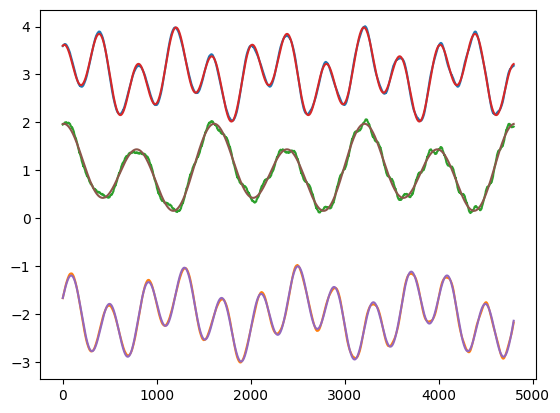

In [9]:
plt.plot(B_est[1].T, label='Cleaned Sensor 0 Estimate')
plt.plot(B0, label='Original Sensor 0')

#### Plot Cleaned Signals and error

Text(0.5, 1.0, 'Error between Cleaned Signal and True Ambient Field')

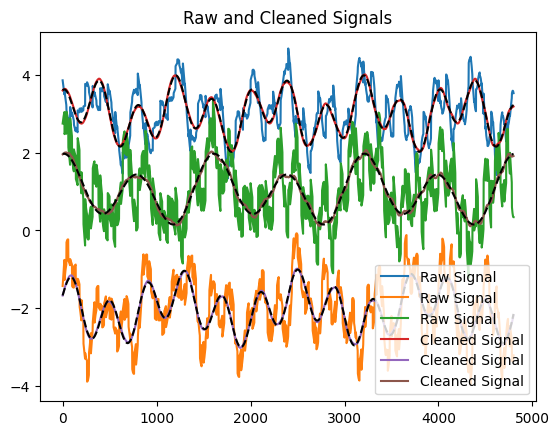

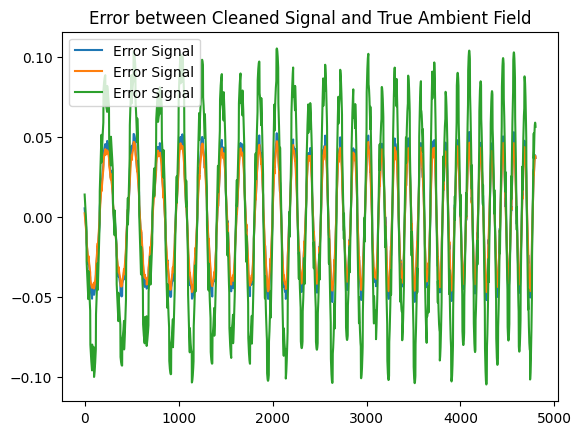

In [10]:
fig, ax = plt.subplots()
plt.plot(B[1].T, label = 'Raw Signal')
plt.plot(B_est[1].T, label = 'Cleaned Signal')
plt.plot(B0, color='black', linestyle='dashed')
plt.title('Raw and Cleaned Signals')
plt.legend()

fig, ax = plt.subplots()
plt.plot(B0 - B_est[0].T, label = 'Error Signal')
plt.legend()
plt.title('Error between Cleaned Signal and True Ambient Field')